# Определение перспективного тарифа для телеком компании
Клиентам федерального оператора сотовой связи "Мегалайн" предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. <br>
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.
### Описание тарифов
#### Тариф «Смарт»
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: <br>
 - минута разговора: 3 рубля <br>
 - сообщение: 3 рубля <br> 
 - 1 Гб интернет-трафика: 200 рублей

#### Тариф «Ультра» <br> 
1. Ежемесячная плата: 1950 рублей <br>
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика <br>
3. Стоимость услуг сверх тарифного пакета: <br>
 - минута разговора: 1 рубль <br>
 - сообщение: 1 рубль <br>
 - 1 Гб интернет-трафика: 150 рублей

## Содержание
1. [Изучение общей информации](#info)
2. [Предобработка данных](#preprocessing)
3. [Анализ данных](#analysis)
4. [Проверка гипотез](#hypotheses)
5. [Общий вывод](#conclusion) 

### Шаг 1. Открываем файл с данными и изучаем общую информацию. <a class="anchor" id="info"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

**Информация о пользователях**

In [3]:
display(users.sample(5))
display(users.duplicated().sum())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
250,1250,20,NaN,Смоленск,Лия,Ракова,2018-04-11,smart
209,1209,27,NaN,Омск,Альбин,Сорокин,2018-06-02,smart
418,1418,30,NaN,Новосибирск,Мстислав,Ахматов,2018-10-23,smart
226,1226,19,NaN,Новосибирск,Альбин,Бобылёв,2018-06-01,ultra
293,1293,39,2018-11-22,Санкт-Петербург,Эдита,Дубинина,2018-09-05,smart


0

In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Каждая строка таблицы - информация о клиенте. <br>
В столбце о дате прекращения пользования тарифом много пропущенных значений. Нам известно, что если значение пропущено, то тариф ещё действовал на момент выгрузки данных. <br>
Дубликатов в данных нет. <br>
Необходимо изменить тип данных значений даты подключения тарифа и даты прекращения пользования в формат даты. 

**Информация о звонках**

In [5]:
display(calls.sample(5))
display(calls.duplicated().sum())

,id,call_date,duration,user_id
138681,1354_89,2018-12-13,13.63,1354
187938,1464_458,2018-11-20,0.00,1464
101654,1262_11,2018-10-23,7.52,1262
170223,1419_296,2018-08-19,13.71,1419
105178,1270_170,2018-11-30,0.68,1270


0

In [6]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [7]:
len(calls[(calls['duration'] > 0) & (calls['duration'] < 1)])

8314

Известно, что «Мегалайн» всегда округляет вверх значения минут. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. В данных есть значения меньше одной минуты, скорее всего технологическая ошибка, округлим значения до 1.

Каждая строка таблицы - информация о звонках пользователей. <br>
Необходимо привести тип данных значений о дате звонка к формату даты.

**Информация о сообщениях**

In [8]:
display(messages.sample(5))
display(messages.duplicated().sum())

,id,message_date,user_id
47465,1209_399,2018-08-22,1209
60372,1265_268,2018-08-20,1265
29739,1130_114,2018-04-27,1130
9333,1038_19,2018-11-09,1038
41603,1176_354,2018-05-29,1176


0

In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Каждая строка таблицы - информация о сообщениях пользователей. <br>
Приведем тип данных значений о дате сообщений к формату даты.

**Информация об интернет-сессиях**

In [10]:
display(internet.head(5))
display(internet.duplicated().sum())

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


0

In [11]:
internet.drop(['Unnamed: 0'], axis='columns', inplace=True)
internet.head(5)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


Каждая строка таблицы - информация об интернет-сессиях пользователей. <br>
Приведем тип данных значений о дате сессии к формату даты.

In [13]:
len(internet[(internet['mb_used'] > 0) & (internet['mb_used'] < 1)])

101

Известно, что «Мегалайн» всегда округляет вверх значения мегабайтов. В данных есть значения меньше одной минуты, скорее всего технологическая ошибка, округлим значения до 1.

**Информация о тарифах**

In [14]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [15]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


### Вывод 
 - Получили общую информацию о каждой таблице <br>
 - Необходимо привести необходимые значения к формату даты <br>
 - Все значения длительности звонков и объема потраченного интернет-трафика необходимо округлить до 1

### Шаг 2. Предобработка данных <a class="anchor" id="preprocessing"></a>

Напишем функцию для приведения нужных значений к формату даты

In [16]:
def value_to_datetime(df, columns):
    for value in columns:
        df[value] = pd.to_datetime(df[value], format='%Y-%m-%d')

In [17]:
# применим функцию и приведем необходимые значения в формат даты 
value_to_datetime(users, ['reg_date', 'churn_date'])
value_to_datetime(calls, ['call_date'])
value_to_datetime(messages, ['message_date'])
value_to_datetime(internet, ['session_date'])

In [18]:
# округляем значения минут. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается 1 минута
calls['duration'] = np.ceil(calls['duration']).astype('int64')

In [19]:
# округляем значения интернет-трафика
internet['mb_used'] = np.ceil(internet['mb_used']).astype('int64')

In [20]:
# в таблице с интернет-трафиком для дальнейшего анализа переведем мб в гб и добавим новый столбец
internet['gb_used'] = internet['mb_used'] / 1024

**Количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя**

In [21]:
# добавим в таблицу со звонками столбец с месяцем
calls['month'] = calls['call_date'].dt.month

In [22]:
calls_pivot_table = calls.pivot_table(index=['user_id', 'month'], values='duration',
                                                   aggfunc=['sum', 'count'])
calls_pivot_table.columns = ['spent_minutes','count_calls']
calls_pivot_table.reset_index().head()

,user_id,month,spent_minutes,count_calls
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58


**Количество отправленных сообщений по месяцам для каждого пользователя**

In [23]:
messages['month'] = messages['message_date'].dt.month

In [24]:
messages_pivot_table = messages.pivot_table(index=['user_id', 'month'], values='id',
    aggfunc='count')
messages_pivot_table.columns = ['count_messages']
messages_pivot_table.reset_index().head()

,user_id,month,count_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


**Объем израсходованного интернет-трафика по месяцам для каждого пользователя**

In [25]:
internet['month'] = internet['session_date'].dt.month

In [26]:
internet_pivot_table = internet.pivot_table(index=['user_id', 'month'], values='gb_used',
    aggfunc='sum')
internet_pivot_table.columns = ['traffic_volume']
internet_pivot_table.reset_index().head()

,user_id,month,traffic_volume
0,1000,5,2.203125
1,1000,6,22.711914
2,1000,7,13.687500
3,1000,8,13.740234
4,1000,9,14.239258


**Помесячная выручка с каждого пользователя**

Объединим таблицы звонков и сообщений по столбцам user_id и month

In [27]:
calls_and_messages = calls_pivot_table.merge(messages_pivot_table, on = ['user_id','month'], how = 'outer').reset_index()
calls_and_messages.sample(5)

,user_id,month,spent_minutes,count_calls,count_messages
2090,1333,11,759.0,103.0,154.0
1789,1285,10,380.0,49.0,86.0
4,1000,9,466.0,58.0,57.0
43,1006,3,286.0,46.0,NaN
2675,1422,10,252.0,34.0,31.0


К получившейся таблице добавим сгрупированную таблицу объема интернет-трафика

In [28]:
full_tariffs = calls_and_messages.merge(internet_pivot_table, on = ['user_id', 'month'], how = 'outer')
full_tariffs.sample(5)

,user_id,month,spent_minutes,count_calls,count_messages,traffic_volume
1917,1307,7,737.0,99.0,24.0,19.374023
1781,1285,2,79.0,10.0,31.0,0.629883
2385,1379,12,1012.0,131.0,104.0,26.551758
1042,1168,5,1232.0,168.0,42.0,25.506836
2448,1388,10,421.0,65.0,NaN,26.167969


Используем метод outer, чтоы не потерять абонентов, которые пользовались звонками или интернетом, но не отправляли сообщения. <br>
К получившейся таблице добавим информацию о пользователях и тарифах.

In [29]:
full_tariffs = full_tariffs.merge(users, on='user_id', how='left')
full_tariffs.sample(5)

,user_id,month,spent_minutes,count_calls,count_messages,traffic_volume,age,churn_date,city,first_name,last_name,reg_date,tariff
2056,1327,12,405.0,54.0,59.0,15.845703,45,NaT,Новороссийск,Клавдия,Севастьянова,2018-04-09,smart
2482,1393,5,574.0,85.0,66.0,19.542969,56,NaT,Краснодар,Артём,Зубков,2018-02-17,smart
1666,1267,12,636.0,89.0,12.0,15.620117,63,NaT,Екатеринбург,Яна,Седова,2018-08-05,smart
1183,1186,11,569.0,76.0,60.0,9.653320,21,NaT,Самара,Рэм,Абакумов,2018-02-02,smart
859,1138,11,526.0,78.0,7.0,21.278320,23,NaT,Екатеринбург,Леся,Ерофеева,2018-07-13,smart


Для того, чтобы к получившейся таблице добавить таблицу о тарифах, необходимо переименовать столбец tariff_name таблицы tariffs

In [30]:
tariffs.columns = ['messages_included', 'mb_per_month_included', 'minutes_included', 'rub_monthly_fee', 'rub_per_gb',
                  'rub_per_message', 'rub_per_minute', 'tariff']
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [31]:
full_tariffs = full_tariffs.merge(tariffs, on ='tariff', how = 'left')
full_tariffs.sample(5) 

,user_id,month,spent_minutes,count_calls,count_messages,traffic_volume,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
823,1132,11,544.0,76.0,NaN,15.729492,24,NaT,Москва,Маргарита,Алехина,2018-09-01,smart,50,15360,500,550,200,3,3
1845,1294,8,308.0,40.0,22.0,18.919922,66,NaT,Владивосток,Дебора,Асафьева,2018-02-20,ultra,1000,30720,3000,1950,150,1,1
2422,1384,7,618.0,88.0,3.0,17.321289,42,NaT,Нижний Новгород,Кристина,Касьянова,2018-04-27,smart,50,15360,500,550,200,3,3
2294,1369,10,177.0,22.0,126.0,22.730469,31,NaT,Краснодар,Валерий,Соловьев,2018-08-18,ultra,1000,30720,3000,1950,150,1,1
2524,1396,11,512.0,68.0,87.0,10.735352,23,NaT,Пенза,Эльга,Савельева,2018-01-12,ultra,1000,30720,3000,1950,150,1,1


Посмотрим, в каких столбцах есть пропущенные значения

In [32]:
full_tariffs.isna().sum()

user_id                     0
month                       0
spent_minutes              40
count_calls                40
count_messages            497
traffic_volume             11
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

Пропущенные значения появились в столбцах:
 - количество сделанных звонков,
 - израсходованные минуты разговора,
 - количество отправленных сообщений,
 - объем израсходованного трафика <br>
Такие пропущенные значения можно объяснить тем, что пользователи не звонили, либо не пользовались интернетом или звонками. Заменим такие значения на 0. <br>
Множество пропущенных значений есть в столбце даты прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных) - оставим, как есть <br>

In [33]:
for column in ['spent_minutes', 'count_calls', 'count_messages', 'traffic_volume']:
    full_tariffs[column] = full_tariffs[column].fillna(0).astype('int64')
full_tariffs.isna().sum()

user_id                     0
month                       0
spent_minutes               0
count_calls                 0
count_messages              0
traffic_volume              0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

Найдем **помесячную выручку с каждого пользователя.** Для этого вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножем на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану.

In [34]:
def ovet_tarif(row):
    calls = (row['spent_minutes'] - row['minutes_included']) * row['rub_per_minute']
    # найдем разницу между израсходованными минутами разговора и количеством минут разговора, включённых в абонентскую плату, 
    # полученную разность умножим на стоимость минуты разговора сверх тарифного пакета
    messages = (row['count_messages'] - row['messages_included']) * row['rub_per_message']
    internet = (row['traffic_volume'] - (row['mb_per_month_included'] / 1024)) * row['rub_per_gb'] 
    # объём интернет-трафика, включённого в абонентскую плату необходимо перевести в Гб
    over_limit = 0
    for i in [calls, messages, internet]:
        if i > 0:
            over_limit += i
    return over_limit

Добавим новый столбец о превышении тарифа по каждому пользователю

In [35]:
full_tariffs['over_tariff_per_user'] = full_tariffs.apply(ovet_tarif, axis = 1)

Добавим новый столбец о помесячной выручки с каждого пользователя (необходимо прибавить ежемесячную абонентскую плату к значение о превышении тарифа).

In [36]:
full_tariffs['revenue_per_user'] = full_tariffs['over_tariff_per_user'] + full_tariffs['rub_monthly_fee']
full_tariffs.sample(5)

,user_id,month,spent_minutes,count_calls,count_messages,traffic_volume,age,churn_date,city,first_name,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,over_tariff_per_user,revenue_per_user
2612,1412,6,551,79,39,24,63,NaT,Волгоград,Геодар,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
2668,1421,6,242,49,52,15,30,NaT,Калининград,Гайдар,...,smart,50,15360,500,550,200,3,3,6.0,556.0
893,1145,4,348,55,60,6,45,NaT,Тюмень,Юлий,...,smart,50,15360,500,550,200,3,3,30.0,580.0
1463,1233,9,663,88,27,20,28,NaT,Воронеж,Сара,...,smart,50,15360,500,550,200,3,3,1489.0,2039.0
367,1057,10,960,130,28,13,43,NaT,Москва,Динара,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0


### Вывод 
 - Привели необходимые значения в формат даты  <br>
 - Округлили значения минут разговора и объема интернет-трафика до бОльшего значения <br>
 - Посчитали для каждого пользователя:
   - количество сделанных звонков и израсходованных минут разговора по месяцам <br>
   - количество отправленных сообщений <br>
   - объем израсходованного интернет-трафика <br>
   - помесячную выручку с каждого пользователя

### Шаг 3. Анализ данных <a class="anchor" id="analysis"></a>

Посмотрим на поведение клиентов, исходя из выборки.

In [37]:
full_tariffs.groupby('tariff')['revenue_per_user'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2229.0,1177.277254,760.340315,550.0,550.0,919.0,1550.0,6570.0
ultra,985.0,2050.659898,338.714798,1950.0,1950.0,1950.0,1950.0,4650.0


- Минимальное значение помесячной выручки с каждого пользователя по двум тарифам - 550руб. (Смарт) и 1950руб. (Ультра). Данные значения являются фиксированной ежемесячной платой по каждому тарифу
- Медиана - 50 % выборки, разделяет выборку на 2 равные части и равна 919руб. (Смарт) и 1950руб. (Ультра)
- Максимальноые значения помесячной выручки - 6570руб. (Смарт) и 4650руб. (Ультра) 

In [38]:
difference = full_tariffs.loc[full_tariffs['tariff'] == 'smart']['revenue_per_user'].sum() - \
            full_tariffs.loc[full_tariffs['tariff'] == 'ultra']['revenue_per_user'].sum()
difference

604251.0

In [39]:
smart_revenue = full_tariffs[full_tariffs['tariff'] == 'smart']['revenue_per_user']
smart_revenue_var = np.var(smart_revenue, ddof=1)
ultra_revenue = full_tariffs[full_tariffs['tariff'] == 'ultra']['revenue_per_user']
ultra_revenue_var = np.var(ultra_revenue, ddof=1)
display(smart_revenue_var)
display(ultra_revenue_var)

578117.3943701962

114727.71449795716

In [40]:
display(np.sqrt(smart_revenue_var))
display(np.sqrt(ultra_revenue_var))

760.3403148394777

338.714798167953

Пользователи тарифа Ультра реже выходят за пределы тарифного пакета и чаще платят только ежемесячный платеж. <br>
Пользователям тарифа Смарт привычнее выходить за рамки тарифного пакета, они чаще оплачивают услуги сверх тарифного пакета.

Посмотрим, как распределены данные по двум тарифам. С целью оптимизации данного процесса напищем функцию **func_hist**, у которой будет 6 аргументов: 
- диапазон значений;
- тариф, который изучаем;
- параметр;
- наименование гистограммы;
- название оси х;
- название оси y

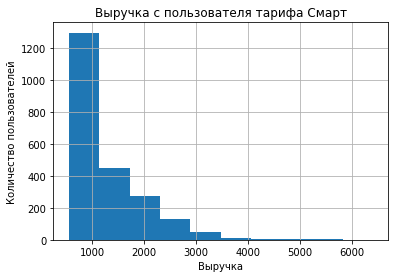

In [41]:
range_hist = [(550, 6400)]
def func_hist (range_hist, tarif, col, title, xname, yname):
    for elem in range_hist:
        x, y = elem
        tarif = full_tariffs[full_tariffs['tariff'] == tarif][col]
        tarif.hist(bins=10, range = (x, y))
        plt.title(title)
        plt.xlabel(xname)
        plt.ylabel(yname)
        plt.show()
func_hist(range_hist, 'smart', 'revenue_per_user', 'Выручка с пользователя тарифа Смарт', 
          'Выручка', 'Количество пользователей')

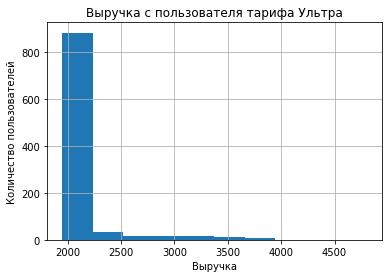

In [42]:
range_hist = [(1950, 4800)]
def func_hist (range_hist, tarif, col, title, xname, yname):
    for elem in range_hist:
        x, y = elem
        tarif = full_tariffs[full_tariffs['tariff'] == tarif][col]
        tarif.hist(bins=10, range = (x, y))
        plt.title(title)
        plt.xlabel(xname)
        plt.ylabel(yname)
        plt.show()
func_hist(range_hist, 'ultra', 'revenue_per_user', 'Выручка с пользователя тарифа Ультра', 
          'Выручка', 'Количество пользователей')

- В нашей выборке **2229 пользователей**, пользующихся тарифом **Смарт** и **985 пользователей** с тарифом **Ультра**.
- Если пользователи тарифа Ультра в основном платят по тарифу фиксированный ежемесячный платеж (в размере 1950руб.) и реже выходят за пределы тарифного пакета, то пользователи тарифа Смарт, наоборот, чаще платят сверх тарифного пакета.

Посмотрим, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитаем среднее количество, дисперсию и стандартное отклонение. Построем гистограммы.

### Минуты разговора

In [43]:
full_tariffs.groupby('tariff')['spent_minutes'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2229.0,417.934948,190.313730,0.0,282.0,422.0,545.0,1435.0
ultra,985.0,526.623350,317.606098,0.0,284.0,518.0,752.0,1673.0


- Минимальные значения минут разговора по обоим тарифов равно 0, предположим, что это пропущенные звонки
- Среднее и медиана по двум тарифам примерно равны

In [44]:
smart_minutes = full_tariffs[full_tariffs['tariff'] == 'smart']['spent_minutes']
smart_minutes_var = np.var(smart_minutes, ddof=1)
ultra_minutes = full_tariffs[full_tariffs['tariff'] == 'ultra']['spent_minutes']
ultra_minutes_var = np.var(ultra_minutes, ddof=1)
display(smart_minutes_var)
display(ultra_minutes_var)

36219.31578434428

100873.63339730098

In [45]:
display(np.sqrt(smart_minutes_var))
display(np.sqrt(ultra_minutes_var))

190.31372988921288

317.6060978591264

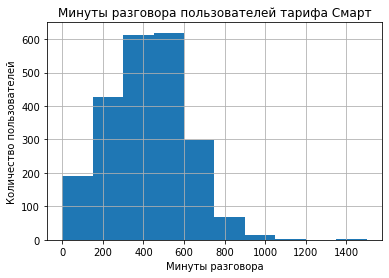

In [46]:
range_hist = [(0, 1500)]
def func_hist (range_hist, tarif, col, title, xname, yname):
    for elem in range_hist:
        x, y = elem
        tarif = full_tariffs[full_tariffs['tariff'] == tarif][col]
        tarif.hist(bins=10, range = (x, y))
        plt.title(title)
        plt.xlabel(xname)
        plt.ylabel(yname)
        plt.show()
func_hist(range_hist, 'smart', 'spent_minutes', 'Минуты разговора пользователей тарифа Смарт', 
          'Минуты разговора', 'Количество пользователей')

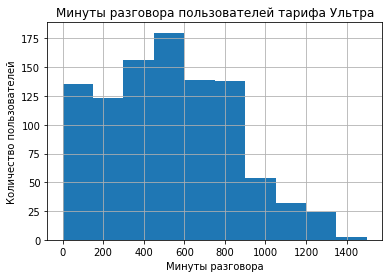

In [47]:
range_hist = [(0, 1500)]
def func_hist (range_hist, tarif, col, title, xname, yname):
    for elem in range_hist:
        x, y = elem
        tarif = full_tariffs[full_tariffs['tariff'] == tarif][col]
        tarif.hist(bins=10, range = (x, y))
        plt.title(title)
        plt.xlabel(xname)
        plt.ylabel(yname)
        plt.show()
func_hist(range_hist, 'ultra', 'spent_minutes', 'Минуты разговора пользователей тарифа Ультра', 
          'Минуты разговора', 'Количество пользователей')

- Пользователи тарифа Смарт в среднем используют 418 минут разговора, они укладываются в пределы тарифного плана (500мин разговора)
- Пользователи тарифа Ультра в среднем используют 527 минут разговора, они "не добирают" около 2500 минут до превышения тарифного плана (3000мин разговора) 
- Распределение минут разговора пользователей тарифа Смарт - нормальное 

### Количество сообщений

In [48]:
full_tariffs.groupby('tariff')['count_messages'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2229.0,33.384029,28.227876,0.0,10.0,28.0,51.0,143.0
ultra,985.0,49.363452,47.804457,0.0,6.0,38.0,79.0,224.0


- Среднее значение по двум тарифам - 33 (Смарт) и 49 сообщений (Ультра)
- Медианы равны 28 и 38 по тарифам Смарт и Ультра соответственно 
- Можно сделать вывод о том, что пользователи не так часто пользуются сообщениями

In [49]:
smart_messages = full_tariffs[full_tariffs['tariff'] == 'smart']['count_messages']
smart_messages_var = np.var(smart_messages, ddof=1)
ultra_messages = full_tariffs[full_tariffs['tariff'] == 'ultra']['count_messages']
ultra_messages_var = np.var(ultra_messages, ddof=1)
display(smart_messages_var)
display(ultra_messages_var)

796.8129584480083

2285.2661425446736

In [50]:
display(np.sqrt(smart_messages_var))
display(np.sqrt(ultra_messages_var))

28.22787555676141

47.804457350174715

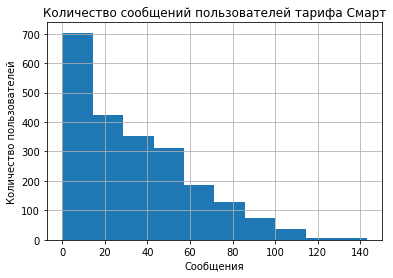

In [51]:
range_hist = [(0, 143)]
def func_hist (range_hist, tarif, col, title, xname, yname):
    for elem in range_hist:
        x, y = elem
        tarif = full_tariffs[full_tariffs['tariff'] == tarif][col]
        tarif.hist(bins=10, range = (x, y))
        plt.title(title)
        plt.xlabel(xname)
        plt.ylabel(yname)
        plt.show()
func_hist(range_hist, 'smart', 'count_messages', 'Количество сообщений пользователей тарифа Смарт', 
          'Сообщения', 'Количество пользователей')

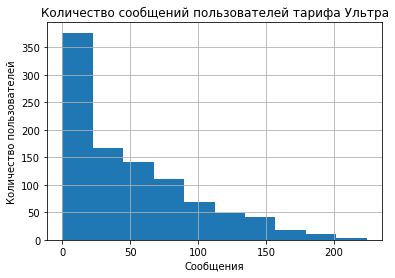

In [52]:
range_hist = [(0, 224)]
def func_hist (range_hist, tarif, col, title, xname, yname):
    for elem in range_hist:
        x, y = elem
        tarif = full_tariffs[full_tariffs['tariff'] == tarif][col]
        tarif.hist(bins=10, range = (x, y))
        plt.title(title)
        plt.xlabel(xname)
        plt.ylabel(yname)
        plt.show()
func_hist(range_hist, 'ultra', 'count_messages', 'Количество сообщений пользователей тарифа Ультра', 
          'Сообщения', 'Количество пользователей')

- В среднем пользователям как тарифа Смарт, так и тарифа Ультра требуется не более 50 сообщений в месяц
- Распределения количества сообщений пользователей обоих тарифов - распределение Пуассона

### Объем интернет-трафика

In [53]:
full_tariffs.groupby('tariff')['traffic_volume'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2229.0,15.360700,5.757206,0.0,12.0,16.0,19.0,37.0
ultra,985.0,18.540102,9.842802,0.0,11.0,18.0,26.0,48.0


- Минимальные значения по обоим тарифам равно 0, предположим, что пользователи не пользуются интернетом
- Медиана тарифа Смарт равна 16Гб, тарифа Ультра - 18Гб
- Максимальные значения обоих тарифов превышают интернет-трафик, включенный в пакет услуг 

In [54]:
smart_internet = full_tariffs[full_tariffs['tariff'] == 'smart']['traffic_volume']
smart_internet_var = np.var(smart_internet, ddof=1)
ultra_internet = full_tariffs[full_tariffs['tariff'] == 'ultra']['traffic_volume']
ultra_internet_var = np.var(ultra_internet, ddof=1)
display(smart_internet_var)
display(ultra_internet_var)

33.145420694887775

96.88075811976393

In [55]:
display(np.sqrt(smart_internet_var))
display(np.sqrt(ultra_internet_var))

5.757205979890573

9.84280235094477

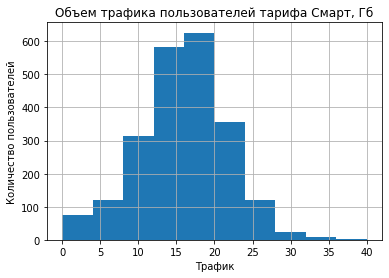

In [56]:
range_hist = [(0, 40)]
def func_hist (range_hist, tarif, col, title, xname, yname):
    for elem in range_hist:
        x, y = elem
        tarif = full_tariffs[full_tariffs['tariff'] == tarif][col]
        tarif.hist(bins=10, range = (x, y))
        plt.title(title)
        plt.xlabel(xname)
        plt.ylabel(yname)
        plt.show()
func_hist(range_hist, 'smart', 'traffic_volume', 'Объем трафика пользователей тарифа Смарт, Гб', 
          'Трафик', 'Количество пользователей')

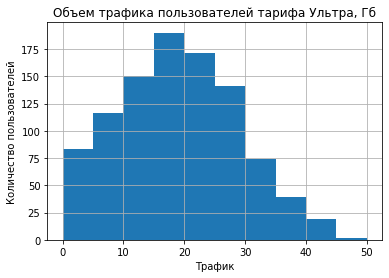

In [57]:
range_hist = [(0, 50)]
def func_hist (range_hist, tarif, col, title, xname, yname):
    for elem in range_hist:
        x, y = elem
        tarif = full_tariffs[full_tariffs['tariff'] == tarif][col]
        tarif.hist(bins=10, range = (x, y))
        plt.title(title)
        plt.xlabel(xname)
        plt.ylabel(yname)
        plt.show()
func_hist(range_hist, 'ultra', 'traffic_volume', 'Объем трафика пользователей тарифа Ультра, Гб', 
          'Трафик', 'Количество пользователей')

- Пользователя тарифа Смарт используют больше Гб интернет-трафика, чем заложено в тарифный план (15Гб), следовательно, они платят 200руб. за каждый дополнительный Гб трафика.
- Пользователи тарифа Ультра в среднем тратят 19Гб трафика, укладываясь в тарифный план (30Гб)
- Распределения объема интернет-трафика обоих тарифов - нормальное

### Вывод 
**1. Выручка.** 
 - В нашей выборке 2229 пользователей, пользующихся тарифом Смарт и 985 пользователей с тарифом Ультра
 - Пользователи тарифа Ультра реже доплачивают за услуги, находящиеся сверх стоимости тарифного плана
 - Пользователи тарифа Смарт чаще доплачивают за дополнительные услуги <br>
 
**2. Минуты разговора.**
 - Пользователи тарифа Смарт в среднем используют 418 минут разговора, они укладываются в пределы тарифного плана (500мин разговора)
 - Пользователи тарифа Ультра в среднем используют 527 минут разговора, они "не добирают" около 2500 минут до превышения тарифного плана (3000мин разговора) <br>
 
**3. Количество сообщений.**
 - Пользователи обоих тарифов одинаково мало пользуются сообщениями (в среднем не более 50 сообщений в месяц) <br>
 
**4. Объем интернет-трафика.**
 - Пользователя тарифа Смарт используют больше Гб интернет-трафика, чем заложено в тарифный план (15Гб), следовательно, они платят 200руб. за каждый дополнительный Гб трафика.
 - Пользователи тарифа Ультра в среднем тратят 19Гб трафика, укладываясь в тарифный план (30Гб)

### Шаг 4. Проверка гипотез <a class="anchor" id="hypotheses"></a>

**Гипотеза. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.** <br>
H0: Выручка пользователей тарифов Смарт и Ультра **не различается** <br>
H1: Выручка пользователей тарифов Смарт и Ультра **различается**

In [58]:
alpha = .05 # критический уровень статистической значимости 
# это тот уровень, который мы принимаем для того, чтобы сказать, что мы считаем «значимым», а что нет
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    full_tariffs[full_tariffs['tariff'] == 'smart']['revenue_per_user'], 
    full_tariffs[full_tariffs['tariff'] == 'ultra']['revenue_per_user']) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 7.304764020044488e-223
Отвергаем нулевую гипотезу


Полученное значение p-value говорит о том, **средняя выручка по тарифам различается.** <br>
**Гипотеза. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается - Подтвердилась**

**Гипотеза. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.** <br>
H0: Средняя выручка пользователей из Москвы **не отличается** от выручки пользователей из других регионов <br>
H1: Средняя выручка пользователей из Москвы **отличается** от выручки пользователей из других регионов

In [59]:
full_tariffs['region'] = np.where(full_tariffs['city'] == 'Москва', 'Москва', 'Другой регион')
full_tariffs.sample(3)

,user_id,month,spent_minutes,count_calls,count_messages,traffic_volume,age,churn_date,city,first_name,...,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,over_tariff_per_user,revenue_per_user,region
3073,1481,8,223,37,25,20,70,NaT,Москва,Клавдия,...,50,15360,500,550,200,3,3,1000.0,1550.0,Москва
1026,1165,10,138,16,107,21,19,NaT,Самара,Алексей,...,1000,30720,3000,1950,150,1,1,0.0,1950.0,Другой регион
2006,1321,3,427,63,23,13,29,NaT,Москва,Онисим,...,50,15360,500,550,200,3,3,0.0,550.0,Москва


In [60]:
moscow = full_tariffs[full_tariffs['region'] == 'Москва']
another_region = full_tariffs[full_tariffs['region'] == 'Другой регион']

In [61]:
moscow = moscow['revenue_per_user']
another_region = another_region['revenue_per_user']

In [62]:
alpha = .05 # критический уровень статистической значимости 

results = st.ttest_ind(moscow, another_region) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.3729729010391226
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что с вероятностью в почти 37% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними выручками.

**Гипотеза. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов - Не подтвердилась**

### Шаг 5. Общий вывод  <a class="anchor" id="conclusion"></a>

В результате работы были выявлены следующие инсайты. 
1. Пользователи тарифа Ультра тратят больше минут разговора и интернет-трафика, отправляют большее сообщений, чем пользователи тарифа Смарт.
2. Пользователей тарифа Смарт в 2 раза больше, чем пользователей тарифа Ультра.
3. Пользователи тарифа Ультра реже превышают лимит своего пакета, чем пользователи тарифа Смарт.
4. Компания получает больше выручки за год с пользователей тарифа Смарт (на 600000руб., чем с пользователей тарифа Ультра). Компания с 1 пользователя тарифа Смарт минимум получает 550руб. (что на 1400руб. меньше, чем с пользователя тарифа Ультра). Пользователей тарифа Смарт количественно больше в 2 раза пользователей тарифа Ультра, годовая выручка с тарифа Смарт больше.
5. Пользователь тарифа Ультра приносит больше выручки, чем пользователей тарифа Смарт.

**Проверка гипотез.** <br>
Гипотеза. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается - **Подтвердилась.** <br>
Гипотеза. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов - **Не подтвердилась.** С вероятностью в почти 37% различие между выборками можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними выручками.